In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pyimagesearch.preprocessing.imagetoarraypreprocessor import ImageToArrayPreprocessor
from pyimagesearch.preprocessing.simplepreprocessor import SimplePreprocessor
from pyimagesearch.datasets.simpledatasetloader import SimpleDatasetLoader
from pyimagesearch.nn.conv.shallownet import ShallowNet
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse 
# example of semi-supervised gan for mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Activation
from matplotlib import pyplot
from keras import backend




In [3]:
# custom activation function
def custom_activation(output):
	logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
	result = logexpsum / (logexpsum + 1.0)
	return result
 
# define the standalone supervised and unsupervised discriminator models
def define_discriminator(in_shape=(32,32,1), n_classes=3):
	# image input
	in_image = Input(shape=in_shape)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output layer nodes
	fe = Dense(n_classes)(fe)
	# supervised output
	c_out_layer = Activation('softmax')(fe)
	# define and compile supervised discriminator model
	c_model = Model(in_image, c_out_layer)
	c_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
	# unsupervised output
	d_out_layer = Lambda(custom_activation)(fe)
	# define and compile unsupervised discriminator model
	d_model = Model(in_image, d_out_layer)
	d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return d_model, c_model

In [4]:
# define the standalone generator model
def define_generator(latent_dim):
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((8, 8, 128))(gen)
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen)
	# define model
	model = Model(in_lat, out_layer)
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect image output from generator as input to discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and outputting a classification
	model = Model(g_model.input, gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [5]:
sp = SimplePreprocessor(32, 32)
iap = ImageToArrayPreprocessor()

imagePaths = list(paths.list_images("./pyimagesearch/datasets/animals"))

sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.astype("float")/255.0


(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)
# trainY = LabelBinarizer().fit_transform(trainY)
# testY = LabelBinarizer().fit_transform(testY)



[INFO] processed 500/3000
[INFO] processed 1000/3000
[INFO] processed 1500/3000
[INFO] processed 2000/3000
[INFO] processed 2500/3000
[INFO] processed 3000/3000


In [23]:
print(trainY.shape)
print(trainY)
k = [1, 5, 6]
trainY_123 = []
dics = {'panda': 1, 'dogs': 2, 'cats': 3}
# print()
trainY_123 = [dics[x] for x in trainY]
trainY_123 = np.array(trainY_123)
print(trainY_123.shape)

(2250,)
['panda' 'dogs' 'cats' ... 'cats' 'cats' 'dogs']
(2250,)


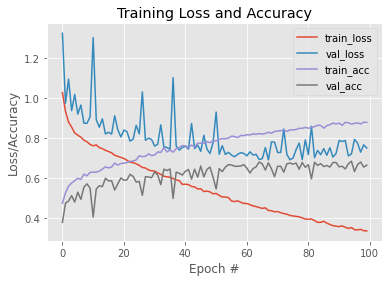

In [4]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
print("[INFO] compiling model ...")
opt = SGD(lr=0.005)
model = ShallowNet.build(width=32, height=32, depth=3, classes = 3)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

#train the network
H = model.fit(trainX, trainY, validation_data=(testX, testY),
            batch_size=32, epochs=100, verbose=1)
model.save("shallownet_weights.hdf5")
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), 
                    target_names=["cat", "dog", "panda"]))